In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

/tmp/ipykernel_354446/2249501015.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
model_dir = '/neurospin/dico/jlaval/Output/5_models_FIP_right_3_layer_proj/16-33-05_0/'
htp_embs = pd.read_csv(os.path.join(model_dir, 'htp_random_embeddings/train_val_embeddings.csv'))

In [3]:
ukb_embs = pd.read_csv(os.path.join(model_dir, 'ukb_random_epoch40_embeddings/full_embeddings.csv'))

In [26]:
dims = [f'dim{k}' for k in range(1,33)]
distrib_htp = cosine_similarity(htp_embs[dims].to_numpy())

In [28]:
distrib_htp -= np.eye(distrib_htp.shape[0])

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 6.0000e+00, 7.8000e+01, 1.4200e+02,
        2.1800e+02, 2.7200e+02, 2.3600e+02, 5.2600e+02, 4.7800e+02,
        6.4000e+01, 2.0000e+01, 1.8000e+01, 3.2000e+01, 9.4000e+01,
        1.8600e+02, 6.1200e+02, 6.2000e+02, 6.9200e+02, 1.5900e+03,
        2.1640e+03, 3.4980e+03, 4.7580e+03, 6.3280e+03, 9.0640e+03,
        1.4526e+04, 2.6510e+04, 5.7464e+04, 1.3486e+05]),
 array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
        -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
        -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
        -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
         0.02564103,  0.07692308,  0.12820513,  0.17948718,  0.23076923,
         0.28205128,  0.33333333,  0.38461538,  0.43589744,  0.48717949,
         0.53846154,  0.5897

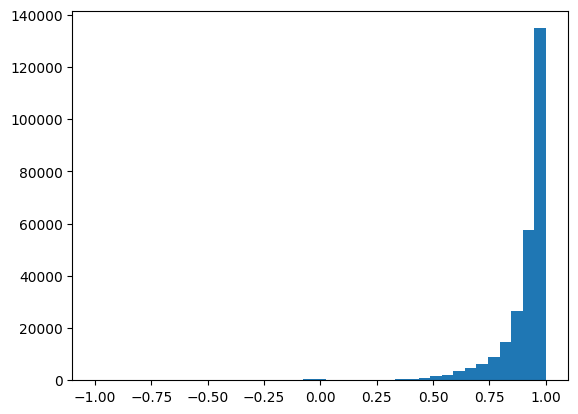

In [27]:
plt.hist(distrib_htp.flatten(), bins=np.linspace(-1,1,40))

In [6]:
distrib_ukb = cosine_similarity(ukb_embs[dims].to_numpy())

In [17]:
distrib_ukb -= np.eye(distrib_ukb.shape[0])

In [18]:
nearest_neighs = np.max(distrib_ukb, axis=0)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,    64.,  3985., 32185.,  6199.]),
 array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
        -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
        -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
        -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
         0.02564103,  0.07692308,  0.12820513,  0.17948718,  0.23076923,
         0.28205128,  0.33333333,  0.38461538,  0.43589744,  0.48717949,
         0.53846154,  0.58974359,  0.64102564,  0.69230769,  0.74358974,
         0.79487179,  0.84615385,  0.8974359 ,  0.94871795,  1.        ]),
 <BarContainer object of 39 artists>)

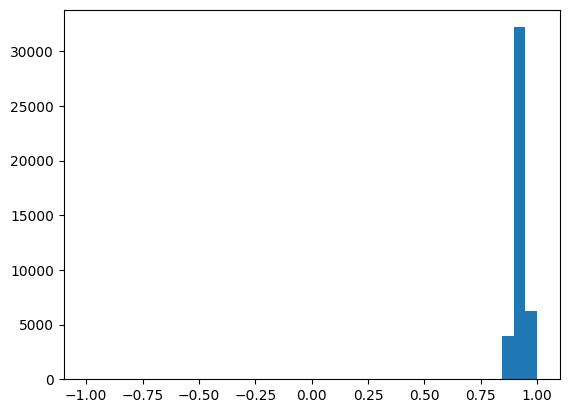

In [19]:
plt.hist(nearest_neighs, bins=np.linspace(-1,1,40))

In [23]:
pd.DataFrame(nearest_neighs).describe()

,0
count,42433.000000
mean,0.926279
std,0.021770
min,0.795702
25%,0.912605
50%,0.927717
75%,0.941603
max,0.999460


In [30]:
## remove value 1 ?
pd.DataFrame(distrib_htp.flatten()).describe()

,0
count,265225.000000
mean,0.901674
std,0.142137
min,-0.352544
25%,0.886947
50%,0.949865
75%,0.976741
max,0.998717


In [32]:
# nearest neigh in htp !
nearest_neigh_htp = np.max(distrib_htp, axis=0)

In [33]:
pd.DataFrame(nearest_neigh_htp.flatten()).describe()

,0
count,515.000000
mean,0.993148
std,0.019798
min,0.770215
25%,0.994544
50%,0.996285
75%,0.997131
max,0.998717


(array([  0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   1.,   1.,   0.,   0.,   2.,   1.,   0.,   3.,   3.,
          8.,  31., 144., 315.]),
 array([0.75      , 0.75423729, 0.75847458, 0.76271186, 0.76694915,
        0.77118644, 0.77542373, 0.77966102, 0.78389831, 0.78813559,
        0.79237288, 0.79661017, 0.80084746, 0.80508475, 0.80932203,
        0.81355932, 0.81779661, 0.8220339 , 0.82627119, 0.83050847,
        0.83474576, 0.83898305, 0.84322034, 0.84745763, 0.85169492,
        0.8559322 , 0.86016949, 0.86440678, 0.86864407, 0.87288136,
        0.87711864, 0.88135593, 0.88559322, 0.88983051, 0.8940678 ,
        0.89830508, 0.90254237, 0.90677966, 0.91101695, 0.91525424,
        0.91949153, 0.92372881, 0.9279661 , 0.932203

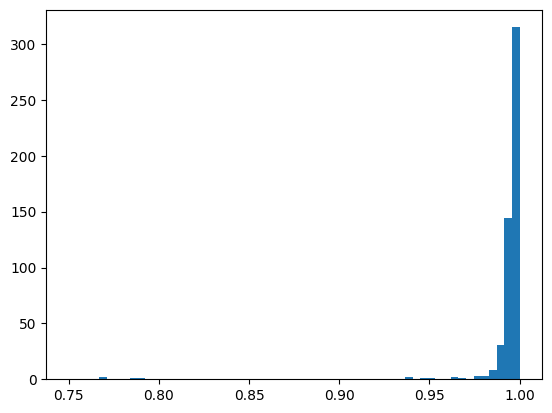

In [37]:
plt.hist(nearest_neigh_htp, bins=np.linspace(0.75, 1, 60))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.100e+01, 1.400e+01, 1.500e+01, 2.400e+01, 3.200e+01,
        4.400e+01, 7.600e+01, 8.300e+01, 1.350e+02, 1.670e+02, 2.410e+02,
        3.590e+02, 5.080e+02, 6.710e+02, 8.610e+02, 1.027e+03, 1.529e+03,
        1.753e+03, 2.150e+03, 2.491e+03, 2.812e+03, 3.080e+03, 3.309e+03,
        3.345e+03, 3.274e+03, 3.185e+03, 2.780e+03, 2.486e+03, 1.911e+03,
        1.435e+03, 1.094e+03, 7.120e+02, 3.740e+02, 2.500e+02, 1.080e+02,
        5.200e+01, 1.600e+01, 2.000e+00, 2.000e+00, 4.000e+00]),
 array([0.75      , 0.75423729, 0.75847458, 0.76271186, 0.76694915,
        0.77118644, 0.77542373, 0.77966102, 0.78389831, 0.78813559,
        0.79237288, 0.79661017, 0.80084746, 0.80508475, 0.80932203,
        0.81355932, 0.81779661, 0.8220339 , 0.82627119, 0.8305084

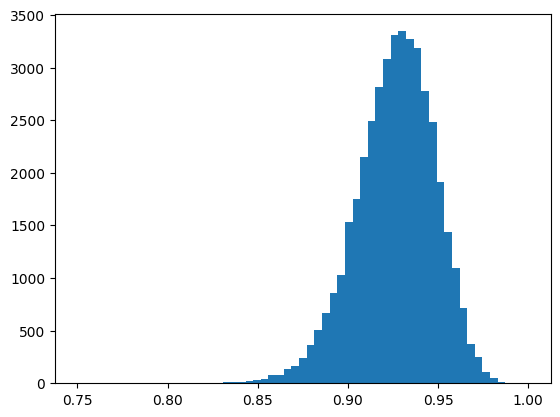

In [38]:
plt.hist(nearest_neighs, bins=np.linspace(0.75, 1, 60))

(array([  246.,   304.,   278.,   300.,   330.,   290.,   346.,   322.,
          370.,   416.,   462.,   514.,   560.,   554.,   592.,   652.,
          674.,   708.,   744.,   776.,   830.,   830.,   890.,   906.,
          924.,  1076.,  1120.,  1140.,  1202.,  1312.,  1342.,  1476.,
         1566.,  1660.,  1804.,  2002.,  2120.,  2196.,  2516.,  2764.,
         2988.,  3258.,  3652.,  4166.,  4720.,  4994.,  5936.,  6358.,
         7388.,  8528., 10144., 11672., 13374., 15774., 19778., 24734.,
        31128., 32898.,  9540.]),
 array([0.5       , 0.50847458, 0.51694915, 0.52542373, 0.53389831,
        0.54237288, 0.55084746, 0.55932203, 0.56779661, 0.57627119,
        0.58474576, 0.59322034, 0.60169492, 0.61016949, 0.61864407,
        0.62711864, 0.63559322, 0.6440678 , 0.65254237, 0.66101695,
        0.66949153, 0.6779661 , 0.68644068, 0.69491525, 0.70338983,
        0.71186441, 0.72033898, 0.72881356, 0.73728814, 0.74576271,
        0.75423729, 0.76271186, 0.77118644, 0.77966102

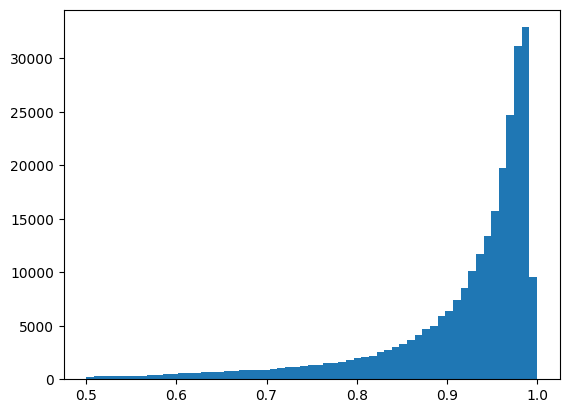

In [41]:
plt.hist(distrib_htp.flatten(), bins=np.linspace(0.5, 1, 60))

## Very heavy here

In [ ]:
## TODO: remove the 1 values in the diagonal

In [ ]:
distrib_ukb = distrib_ukb.flatten()

(array([0.00000000e+00, 0.00000000e+00, 1.15800000e+03, 2.79920000e+04,
        2.06908000e+05, 8.06008000e+05, 2.20851000e+06, 4.81467400e+06,
        8.94660400e+06, 1.48220740e+07, 2.24765140e+07, 3.18293100e+07,
        4.25461740e+07, 5.42280620e+07, 6.63428240e+07, 7.83585280e+07,
        8.96483300e+07, 9.96433120e+07, 1.07856128e+08, 1.13911916e+08,
        1.17432034e+08, 1.18379940e+08, 1.16603776e+08, 1.12363570e+08,
        1.05702466e+08, 9.71103060e+07, 8.69079280e+07, 7.56126620e+07,
        6.37233580e+07, 5.18009220e+07, 4.03730360e+07, 2.98480360e+07,
        2.06722540e+07, 1.31197960e+07, 7.36683000e+06, 3.43438800e+06,
        1.16953800e+06, 2.13806000e+05, 3.61530000e+04]),
 array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
        -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
        -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
        -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
  

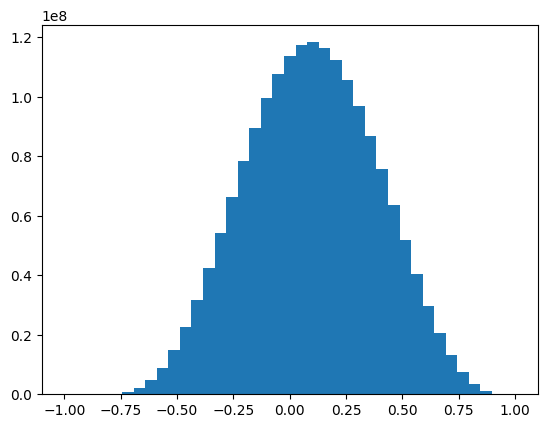

In [23]:
plt.hist(distrib_ukb, bins=np.linspace(-1,1,40))

In [26]:
# AUC
distrib = distrib_ukb.tolist() + distrib_htp.tolist()
labels = [0 for k in range(len(distrib_ukb))] + [1 for k in range(len(distrib_ukb))]

ValueError: operands could not be broadcast together with shapes (1800559489,) (265225,) 

In [ ]:
distrib